## Tool for Forecasting Estore Sales
In this Notebook, I build a sales forecasting tool and we then use it for each E-store on the platform.

After looking up different methods for time-series forecasting and the available tools/libraries, I decided to use Prophet (https://facebook.github.io/prophet/) for the purpose of developing a tool that can allow E-stores to forecast/predict future sales. From what I learned, Prophet uses a decomposable time series model with three main components model componets: trends, seasonality and holidays. Therefore, it is perfectly suited for the available sales data that we have for the E-stores on our platform. 

In [1]:
# Loading relevant Python packages and libraries
import pandas as pd
import os
import numpy as np
import seaborn as sns; sns.set()
sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
%matplotlib inline
from operator import attrgetter
import matplotlib.colors as mcolors
from prophet import Prophet
import datetime

In [2]:
# Loading the provided CSV file as a Pandas DataFrame
data = pd.read_csv("ecommerce_data.csv")

In [3]:
# Loading the data files we generated in the Initial_Data_Exploration Notebook
data_positive_quantity = pd.read_csv('data_positive_quantity.csv')
data_negative_quantity = pd.read_csv('data_negative_quantity.csv')

For a first attempt, we will work with the provided data ("ecommerce_data.csv") which also contains data for returns/refunds etc. Since we are interested in Sales forecasting, we will define the TotalPrice column (like we did previously), by multiplying the UnitPrice and Quantity Columns. We know that there are many missing entries in the Quantity column, so we will replace NaN with 1, like we did in Initial_Data_Exploration Notebook and then define the TotalPrice column.

In [4]:
data["Quantity"] = data["Quantity"].fillna(1)
data["TotalPrice"] = data["Quantity"]*data["UnitPrice"]

In [5]:
# Converting Invoice Date column to datetime format

data['InvoiceDate'] =  pd.to_datetime(data['InvoiceDate'], infer_datetime_format=True)

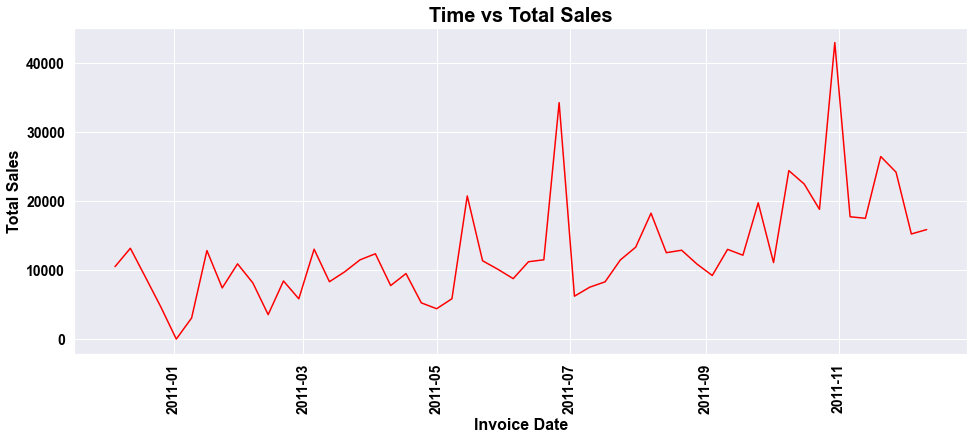

In [6]:
# Checking Total Sales of All E-stores on Globosales platform by grouping the data for every week using the InvoiceDate
# and by summing up the Total Sale Price
df1 = data.groupby(pd.Grouper(freq='W', key='InvoiceDate'))['TotalPrice'].sum()
plt.figure(figsize=(16, 6))
plt.plot(df1, color='red')
plt.title("Time vs Total Sales", fontweight='bold', color = 'black', fontsize='20', horizontalalignment='center')
plt.xticks(rotation='vertical', fontsize=14, fontweight='bold', color = 'black')
plt.xlabel('Invoice Date', fontweight='bold', color = 'black', fontsize='16', horizontalalignment='center')
plt.ylabel('Total Sales', fontweight='bold', color = 'black', fontsize='16', horizontalalignment='center')
plt.yticks(fontsize=14, fontweight='bold', color = 'black')
plt.show()

Figure above shows the Total Sales (unit price * quantity) for all available E-stores on the platform. As a first attempt at using prophet, we will use this data to forecast future sales for the whole platform.

In [7]:
# Using Prophet on df1 above

prophet_df = df1.reset_index()
prophet_df['ds']=prophet_df['InvoiceDate']
prophet_df['y']=prophet_df['TotalPrice']
m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
# In the line above, we used yearly, weekly and daily seasonality trends. 
m.fit(prophet_df)

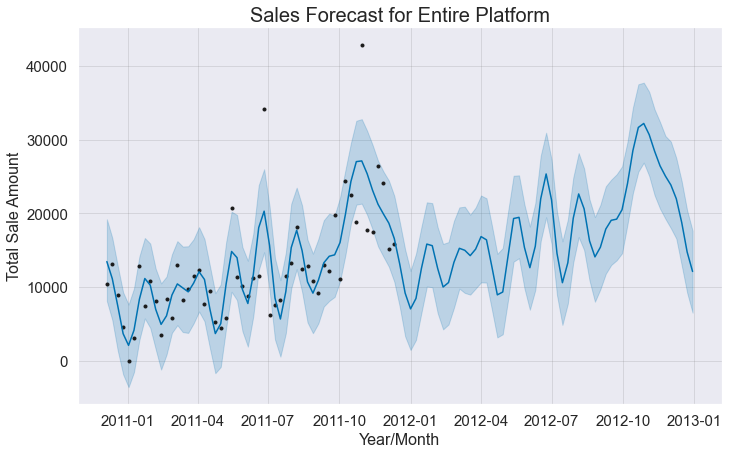

In [8]:
#forecasting with prophet for 55 weeks in the future.
future = m.make_future_dataframe(periods=55,freq = "W")
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#plotting forecasted sales for the platform
fig1 = m.plot(forecast)
ax = fig1.gca()
ax.set_title("Sales Forecast for Entire Platform", size=20)
ax.set_xlabel("Year/Month", size=16)
ax.set_ylabel("Total Sale Amount", size=16)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)

From the plot above, we can see predicted sales for the entire platform up until 2013. The forecast is taking into account trends in data, we can see that peak is predicted before the holiday season. Below, we can plot the components for the forecast carried out by Prophet. If I had more time, I would have explored these components in more detail to find meaningful trends and checking how enabling or disabling them would affect the results. From the analysis I did on this, it seems yearly seasonality has a strong influence on the time series data that was grouped using weeks. I would also like to check how results change if we use different groupings.

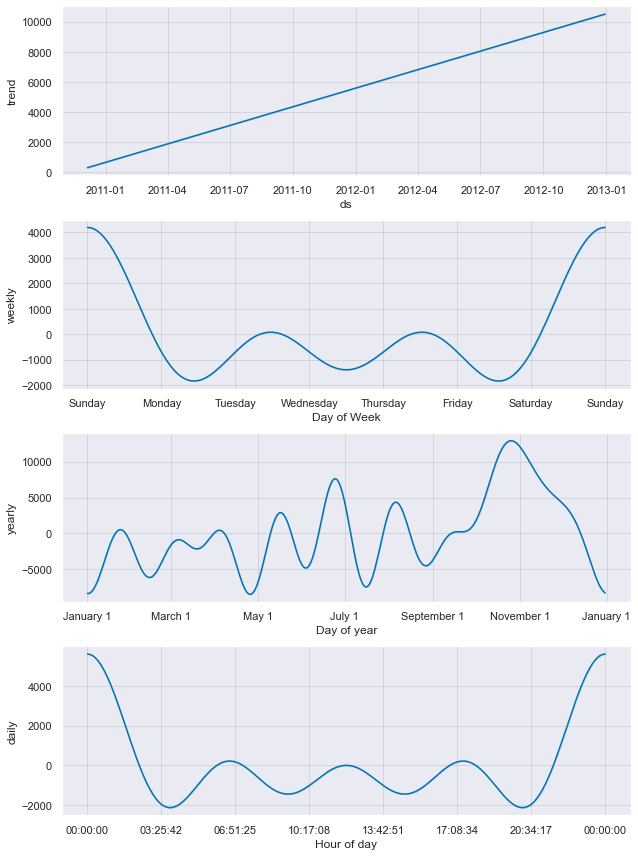

In [9]:
fig2 = m.plot_components(forecast) 

Now that we know prophet works, we can use it to make forecasts for individual E-stores.

In [10]:
# First we will define a function to run prophet (with yearly seasonality taken into account) for a given estore_id

def run_prophet(estore_id):
    prophet_df = data[data['Estore_id']==estore_id].groupby(pd.Grouper(freq='W', key='InvoiceDate'))['TotalPrice'].sum().reset_index()
    prophet_df['ds']=prophet_df['InvoiceDate']
    prophet_df['y']=prophet_df['TotalPrice']
    m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
    m.fit(prophet_df)
    return m

Above we have created a function above (run_prophet_weekly) which can be called with the Estore_id to utilize the data and predict sales for a given Estore using yearly seasonality trends. Now we will test on Estore with id 1.

In [11]:
m = run_prophet(1)

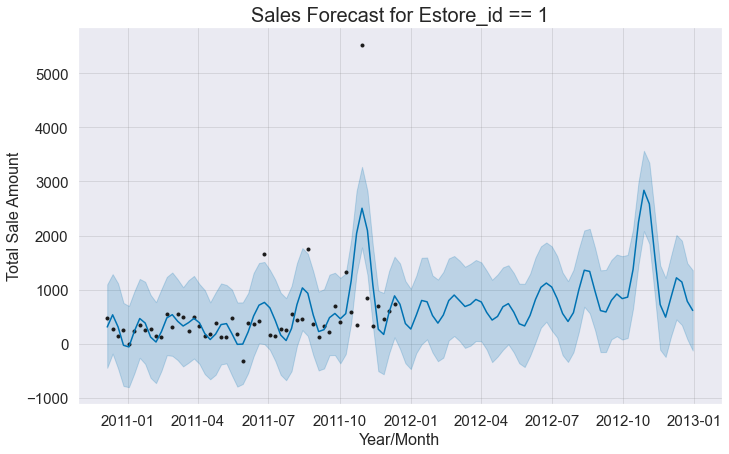

In [12]:
future = m.make_future_dataframe(periods=55,freq = "W")
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
ax = fig1.gca()
ax.set_title("Sales Forecast for Estore_id == 1", size=20)
ax.set_xlabel("Year/Month", size=16)
ax.set_ylabel("Total Sale Amount", size=16)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)

The figure above shows the forecasted sales for the Estore which has an id of 1. We can define another Prophet function that can take into account daily seasonality (to check for trends for week days, holidays etc):

In [13]:
def run_prophet_daily(estore_id):
    #grouping data by day instead of week in the following line:
    prophet_df = data[data['Estore_id']==estore_id].groupby(pd.Grouper(freq='D', key='InvoiceDate'))['TotalPrice'].sum().reset_index()
    prophet_df['ds']=prophet_df['InvoiceDate']
    prophet_df['y']=prophet_df['TotalPrice']
    m = Prophet(daily_seasonality=True)
    m.fit(prophet_df)
    return m

In [14]:
# running the function defined above for estore with ID 1
m = run_prophet_daily(1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


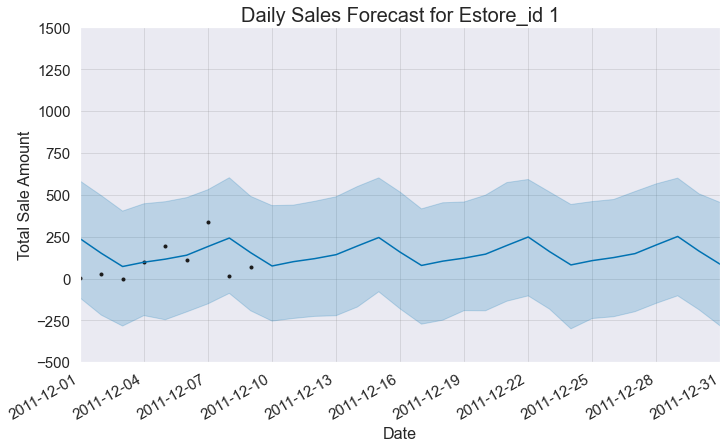

In [15]:
#plotting forecasted data (100 days in the future)
future = m.make_future_dataframe(periods=100,freq = "D")
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig2 = m.plot(forecast)
ax = fig2.gca()
ax.set_title("Daily Sales Forecast for Estore_id 1", size=20)
ax.set_xlabel("Date", size=16)
ax.set_ylabel("Total Sale Amount", size=16)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xlim([datetime.date(2011, 12, 1), datetime.date(2011, 12, 31)])
ax.set_ylim(-500, 1500)
fig2.autofmt_xdate()

From the figure above, we can predict the daily sales for Estore 1, we find that there is peak in orders towards the end of the week on Fridays.

Now we can call the run_prophet function that we have defined inside a loop for all E-store IDs and generate figures showing their sales forecast for the year 2012.

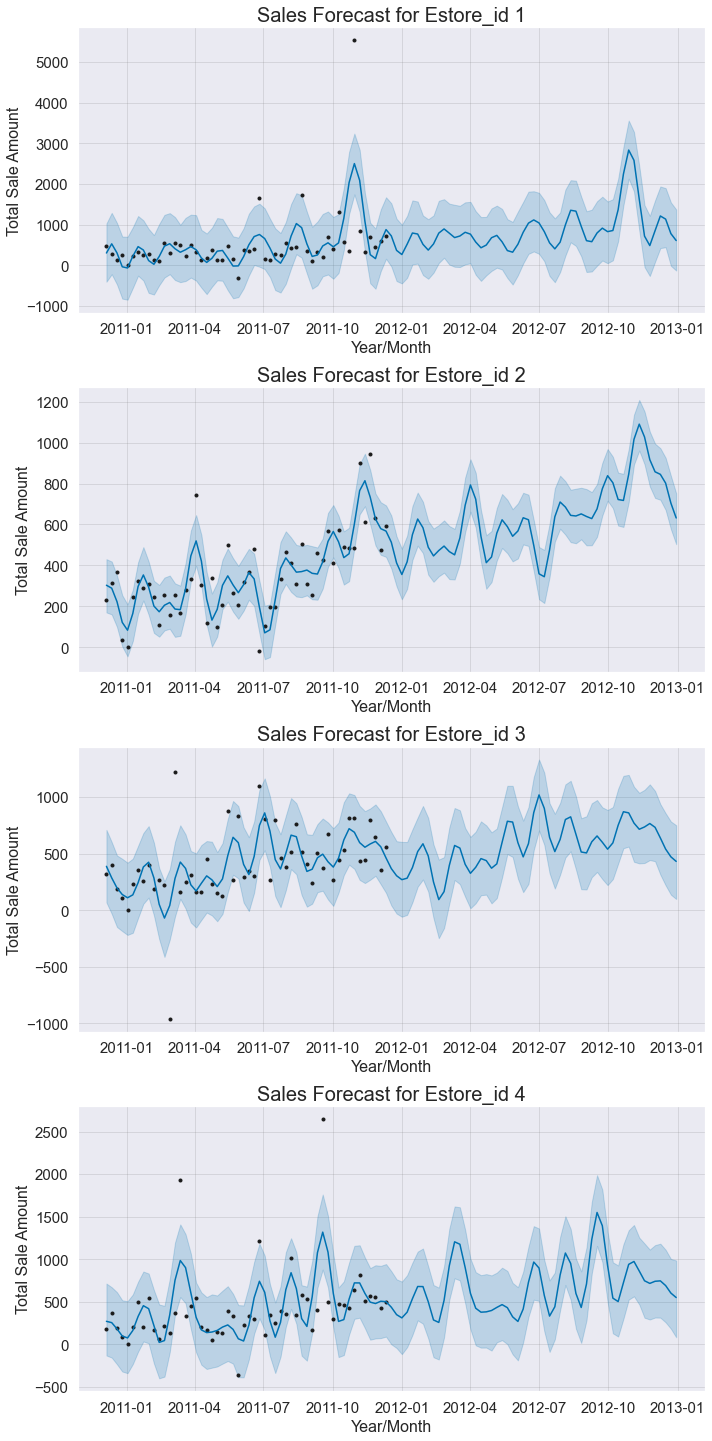

In [16]:
#making forecasts for first E-stores with Ids between 1 to 4
fig, axs = plt.subplots(4,figsize=(10,20))
for i in range(1,5): #looping over E-store ID
    m = run_prophet(i)
    future = m.make_future_dataframe(periods=55,freq = "W")
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast,ax=axs[i-1])
    axs[i-1].set_title("Sales Forecast for Estore_id "+str(i), size=20)
#    ax = fig1.gca()
#    ax.set_title("Sales Forecast for Estore_id "+str(i), size=20)
    axs[i-1].set_xlabel("Year/Month", size=16)
    axs[i-1].set_ylabel("Total Sale Amount", size=16)
    axs[i-1].tick_params(axis="x", labelsize=15)
    axs[i-1].tick_params(axis="y", labelsize=15)

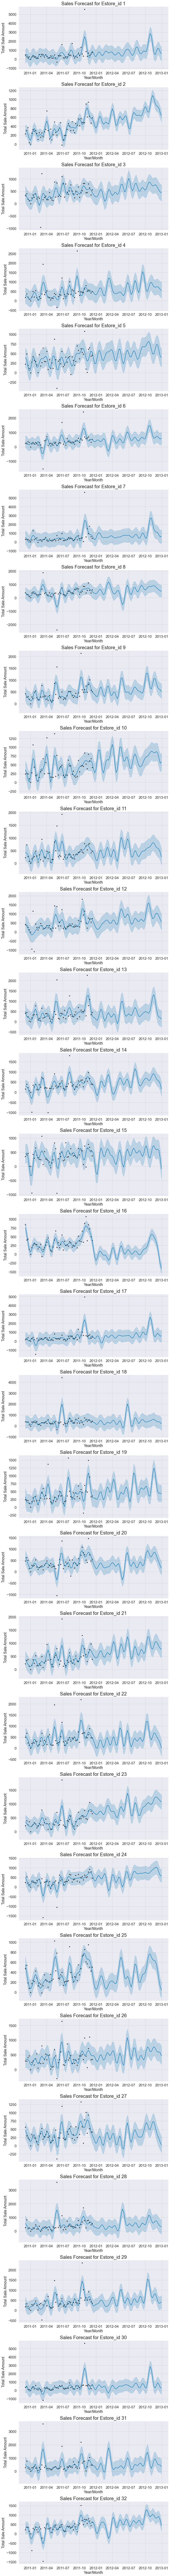

In [17]:
#making forecast plots for all E-stores (with Ids values between 1 to 32)
fig, axs = plt.subplots(32,figsize=(10,150))
#axs.set_title("Sales Forecast for Estore_id "+str(i), size=20)
#fig.suptitle('E-store-Predictions')
for i in range(1,33):
    m = run_prophet(i)
    future = m.make_future_dataframe(periods=55,freq = "W")
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast,ax=axs[i-1])
    axs[i-1].set_title("Sales Forecast for Estore_id "+str(i), size=20)
#    ax = fig1.gca()
#    ax.set_title("Sales Forecast for Estore_id "+str(i), size=20)
    axs[i-1].set_xlabel("Year/Month", size=16)
    axs[i-1].set_ylabel("Total Sale Amount", size=16)
    axs[i-1].tick_params(axis="x", labelsize=15)
    axs[i-1].tick_params(axis="y", labelsize=15)

In the plots above, we can see forecasted sales for all the E-stores on our platform. A number of E-stores (e.g., those with ids 1,2,5,6,7,8,12,13) show significant seasonality with peak in sale amounts close to November/Decemer. Below we run propher on Estore with ID 24. This E-store had the lowest number of total sales.

In [18]:
m = run_prophet(24)

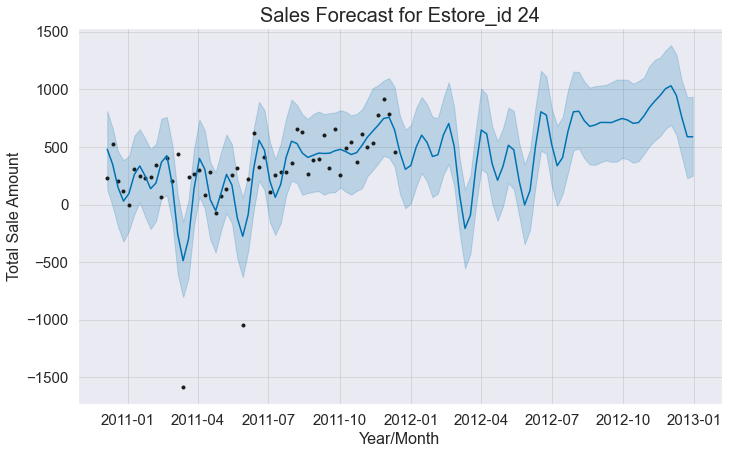

In [19]:
future = m.make_future_dataframe(periods=55,freq = "W")
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
ax = fig1.gca()
ax.set_title("Sales Forecast for Estore_id 24", size=20)
ax.set_xlabel("Year/Month", size=16)
ax.set_ylabel("Total Sale Amount", size=16)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)